In [1]:
import xarray as xr
import pandas as pd
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

from RU29_helpers import grid_glider

import numpy as np

In [2]:
# read in the list of start and end times
# need to make sure the dates are interperted as dates!
sect_times = pd.read_csv('anagada_section_times.csv', parse_dates=[1,2])

print(sect_times.info())

sect_times.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23 entries, 0 to 22
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   section_number  23 non-null     int64         
 1   starttime       23 non-null     datetime64[ns]
 2   endtime         23 non-null     datetime64[ns]
dtypes: datetime64[ns](2), int64(1)
memory usage: 680.0 bytes
None


,section_number,starttime,endtime
0,0,2020-09-13 15:21:18,2020-09-15 06:58:35
1,1,2020-10-01 00:26:24,2020-10-03 00:46:16
2,2,2020-10-06 20:48:49,2020-10-08 13:48:27
3,3,2020-10-08 13:48:27,2020-10-10 13:04:46
4,4,2020-10-10 13:04:46,2020-10-12 02:23:15


In [3]:
# get the glider data:

dataid = 'ru29-20200908T1623-profile-sci-rt'

ru29ds = grid_glider(dataid)

/Users/tnmiles/opt/anaconda3/envs/masters/lib/python3.9/site-packages/scipy/stats/_binned_statistic.py:648: RuntimeWarning: Mean of empty slice
  result[vv, i] = stat_func(bin_map[i])
/Users/tnmiles/opt/anaconda3/envs/masters/lib/python3.9/site-packages/scipy/stats/_binned_statistic.py:648: RuntimeWarning: Mean of empty slice
  result[vv, i] = stat_func(bin_map[i])


In [4]:
ru29ds

<xarray.Dataset>
Dimensions:                (date: 1090, depth: 199)
Coordinates:
  * date                   (date) datetime64[ns] 2020-09-08T16:45:31.84337305...
  * depth                  (depth) float64 2.5 7.5 12.5 ... 982.5 987.5 992.5
    lat                    (date) float64 18.18 18.18 18.18 ... 18.16 18.16
    lon                    (date) float64 -64.8 -64.81 -64.8 ... -64.79 -64.79
Data variables:
    u                      (date) float64 nan nan nan ... 0.002537 nan -0.03963
    v                      (date) float64 nan nan nan ... -0.01012 nan 0.01019
    potential_temperature  (depth, date) float64 nan nan nan nan ... nan nan nan
    salinity               (depth, date) float64 nan nan nan nan ... nan nan nan
    cdom                   (depth, date) float64 nan nan nan nan ... nan nan nan
    chlorophyll_a          (depth, date) float64 nan nan nan nan ... nan nan nan
    beta_700nm             (depth, date) float64 nan nan nan nan ... nan nan nan

In [5]:
# select just a single section 

start = sect_times.iloc[0].starttime
stop = sect_times.iloc[0].endtime

sec = ru29ds.sel(date = slice(start, stop))

# print out what your selected dataset
sec

<xarray.Dataset>
Dimensions:                (date: 25, depth: 199)
Coordinates:
  * date                   (date) datetime64[ns] 2020-09-13T15:21:18.54965913...
  * depth                  (depth) float64 2.5 7.5 12.5 ... 982.5 987.5 992.5
    lat                    (date) float64 18.14 18.13 18.11 ... 17.83 17.82
    lon                    (date) float64 -64.77 -64.77 -64.77 ... -64.8 -64.79
Data variables:
    u                      (date) float64 nan -0.1233 nan ... nan -0.07592 nan
    v                      (date) float64 nan 0.01614 nan ... nan 0.01256 nan
    potential_temperature  (depth, date) float64 29.64 29.72 29.72 ... nan nan
    salinity               (depth, date) float64 34.63 34.63 34.58 ... nan nan
    cdom                   (depth, date) float64 nan 0.0 nan 0.0 ... nan nan nan
    chlorophyll_a          (depth, date) float64 nan 0.0 nan 0.0 ... nan nan nan
    beta_700nm             (depth, date) float64 nan 0.0 nan 0.0 ... nan nan nan

In [6]:
# grab bathymetry data for a map

lat_lims = [16, 18.9]
lon_lims = [-66, -61]

# grab some bathymetry

url = 'http://geoport.whoi.edu/thredds/dodsC/bathy/etopo1_bed_g2'

etopo1 = xr.open_dataset(url).sel(lat = slice(lat_lims[0], lat_lims[1]), lon = slice(lon_lims[0], lon_lims[1] ))

# make the figure code better!

In [7]:
def plot_section(sec):
    plt.figure( figsize = (10,5))

    plt.subplot(121)

    plt.pcolormesh(sec.lat, sec.depth, sec.potential_temperature )
#     plt.contourf(sec.lat, sec.depth, sec.potential_temperature )
    plt.ylim([1000, 0])
    plt.colorbar(label='Temp [$^\circ$C]')
    plt.xlabel('Latitude')
    plt.ylabel('Depth [m]')

    plt.title( str(sec.date[0].dt.month.values) + '/' + str(sec.date[0].dt.day.values)
              +' - ' + str(sec.date[-1].dt.month.values) + 
              '/' + str(sec.date[-1].dt.day.values) + ', '+ str(sec.date[-1].dt.year.values))

    ax = plt.subplot(122, projection= ccrs.Mercator())

    ax.coastlines()
    dpth_contours = np.append(np.arange(-5000, -500, 500), np.arange(-500, 0, 50)) 

    plt.contourf( etopo1.lon, etopo1.lat, etopo1.topo, dpth_contours , 
                 transform=ccrs.PlateCarree(), cmap='Blues_r', zorder=0)

    # plt.pcolormesh(etopo1.lon, etopo1.lat, etopo1.topo, transform=ccrs.PlateCarree(), vmin=-4000, vmax=0, cmap="Blues_r")

    plt.plot(ru29ds.lon, ru29ds.lat, 'k.', 
             transform=ccrs.PlateCarree())
    plt.plot(sec.lon, sec.lat, 'r.', transform=ccrs.PlateCarree())

    ax.set_extent((-65.0,-64.5, 17.6, 18.5) )

    ax.gridlines(draw_labels=True)

In [8]:
def get_dist_from_point( inlat, inlon, origlat, origlon):
    """ return a vector of distances from an origin """
    import geopy.distance
    out_vec = np.empty_like(inlon) 
    
    for j in range(len(inlon)):
        if np.isnan(inlon[j]):
            out_vec[j] = np.NaN
        else:
            out_vec[j] = geopy.distance.distance((inlat[j], inlon[j]), (origlat, origlon)).km
    return out_vec

In [9]:
southern_point = sec.lat.argmin().values
southern_point

array(24)

In [12]:
# get the distance from the southernmost point
dist = get_dist_from_point( sec.lat, sec.lon, 
                           sec.lat[southern_point], sec.lon[southern_point])

In [13]:
# add the distance to the dataframe
# sec['distance'] = (('date'), dist)
sec = sec.assign_coords(distance = ('date', dist))
sec

<xarray.Dataset>
Dimensions:                (date: 25, depth: 199)
Coordinates:
  * date                   (date) datetime64[ns] 2020-09-13T15:21:18.54965913...
  * depth                  (depth) float64 2.5 7.5 12.5 ... 982.5 987.5 992.5
    lat                    (date) float64 18.14 18.13 18.11 ... 17.83 17.82
    lon                    (date) float64 -64.77 -64.77 -64.77 ... -64.8 -64.79
    distance               (date) float64 35.11 34.24 32.64 ... 2.319 1.165 0.0
Data variables:
    u                      (date) float64 nan -0.1233 nan ... nan -0.07592 nan
    v                      (date) float64 nan 0.01614 nan ... nan 0.01256 nan
    potential_temperature  (depth, date) float64 29.64 29.72 29.72 ... nan nan
    salinity               (depth, date) float64 34.63 34.63 34.58 ... nan nan
    cdom                   (depth, date) float64 nan 0.0 nan 0.0 ... nan nan nan
    chlorophyll_a          (depth, date) float64 nan 0.0 nan 0.0 ... nan nan nan
    beta_700nm             (depth, date) float64 nan 0.0 nan 0.0 ... nan nan nan

<ipython-input-7-1634e642a96d>:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(sec.lat, sec.depth, sec.potential_temperature )


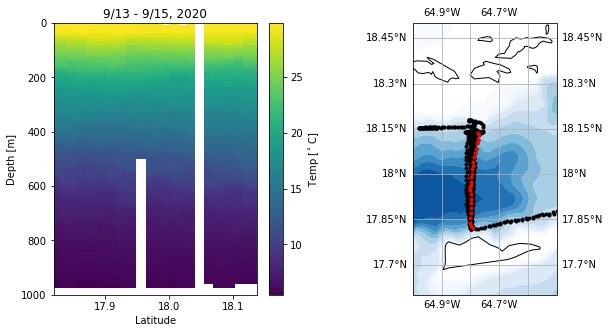

In [14]:
plot_section(sec)

In [16]:
# make a loop to 'process' the data into sections:
# first need to make a directory to save into

for ind in range(len(sect_times)):
    print(ind)
    
    # get the start and end times
    start = sect_times.iloc[ind].starttime
    stop = sect_times.iloc[ind].endtime
    
    # grab just this section
    sec = ru29ds.sel(date = slice(start, stop))
    
    # get the index of the southernmost point
    southern_point = sec.lat.argmin().values
    
    # get the distance from the southernmost point
    dist = get_dist_from_point( sec.lat, sec.lon, 
                           sec.lat[southern_point], sec.lon[southern_point])
    
    # add the distance as a coordinate:
    sec = sec.assign_coords(distance = ('date', dist))
    
    # make a filename:
    save_path = './processed_sections/'
    fname = 'section' + str(ind) + '.nc'
    # save this section:
    sec.to_netcdf(save_path + fname)
#     plot_section(sec)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
